In [31]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 512
MODEL_NAME = 'baseline'

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [6]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [7]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [8]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

In [9]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=32, pin_memory=True,
                                   shuffle=True, drop_last=True)

315113it [10:08, 803.21it/s]

In [10]:
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=32, pin_memory=True,
                                 shuffle=False, drop_last=False)


0it [00:00, ?it/s]
8399it [00:00, 83989.08it/s]
19511it [00:00, 90625.96it/s]
30948it [00:00, 96642.86it/s]
42527it [00:00, 101686.08it/s]
54132it [00:00, 105605.54it/s]
65795it [00:00, 108686.45it/s]
80405it [00:00, 117728.94it/s]
96272it [00:00, 127606.30it/s]
112100it [00:00, 135480.75it/s]
127962it [00:01, 141680.26it/s]
143820it [00:01, 146357.59it/s]
159778it [00:01, 150087.21it/s]
174917it [00:01, 144159.19it/s]
189474it [00:01, 131877.41it/s]
202964it [00:01, 128646.60it/s]
216058it [00:01, 127516.51it/s]
228973it [00:01, 126919.32it/s]
241780it [00:01, 126472.07it/s]
255118it [00:01, 128466.67it/s]
270480it [00:02, 135103.04it/s]
286383it [00:02, 141488.27it/s]
301975it [00:02, 145527.46it/s]
316679it [00:04, 24378.61it/s] 
327220it [00:15, 2822.12it/s] 
327313it [00:15, 1708.06it/s]
327405it [00:15, 1351.44it/s]
327497it [00:15, 1174.45it/s]
327588it [00:15, 1070.95it/s]
327679it [00:15, 1012.01it/s]
327770it [00:16, 972.40it/s] 
327860it [00:16, 948.97it/s]
327950it [00:16,

347916it [00:38, 859.02it/s]
348006it [00:38, 869.60it/s]
348095it [00:39, 875.60it/s]
348184it [00:39, 879.44it/s]
348273it [00:39, 881.25it/s]
348363it [00:39, 886.62it/s]
348454it [00:39, 891.49it/s]
348544it [00:39, 893.68it/s]
348634it [00:39, 893.62it/s]
348724it [00:39, 895.39it/s]
348814it [00:39, 895.06it/s]
348904it [00:39, 893.46it/s]
348995it [00:40, 897.34it/s]
349085it [00:40, 896.62it/s]
349175it [00:40, 897.41it/s]
349265it [00:40, 894.53it/s]
349356it [00:40, 896.95it/s]
349447it [00:40, 897.91it/s]
349538it [00:40, 898.71it/s]
349628it [00:40, 895.31it/s]
349719it [00:40, 897.55it/s]
349809it [00:40, 896.39it/s]
349900it [00:41, 898.26it/s]
349991it [00:41, 900.61it/s]
350082it [00:41, 897.89it/s]
350172it [00:41, 895.96it/s]
350262it [00:41, 894.86it/s]
350352it [00:41, 895.38it/s]
350443it [00:41, 898.57it/s]
350533it [00:41, 896.64it/s]
350624it [00:41, 898.17it/s]
350715it [00:41, 899.47it/s]
350805it [00:42, 899.40it/s]
350895it [00:42, 899.40it/s]
350986it [00:4

370897it [01:04, 891.91it/s]
370988it [01:04, 895.27it/s]
371078it [01:05, 894.34it/s]
371168it [01:05, 894.18it/s]
371258it [01:05, 893.43it/s]
371348it [01:05, 891.23it/s]
371438it [01:05, 891.02it/s]
371528it [01:05, 891.46it/s]
371618it [01:05, 892.02it/s]
371708it [01:05, 892.19it/s]
371799it [01:05, 895.01it/s]
371889it [01:06, 894.96it/s]
371980it [01:06, 897.98it/s]
372070it [01:06, 897.29it/s]
372160it [01:06, 896.68it/s]
372250it [01:06, 895.55it/s]
372340it [01:06, 894.08it/s]
372430it [01:06, 893.22it/s]
372521it [01:06, 896.81it/s]
372611it [01:06, 894.50it/s]
372701it [01:06, 893.28it/s]
372791it [01:07, 894.94it/s]
372881it [01:07, 895.71it/s]
372971it [01:07, 896.33it/s]
373061it [01:07, 877.24it/s]
373149it [01:07, 875.35it/s]
373237it [01:07, 873.61it/s]
373326it [01:07, 875.88it/s]
373417it [01:07, 883.17it/s]
373507it [01:07, 886.37it/s]
373597it [01:07, 888.53it/s]
373688it [01:08, 892.20it/s]
373778it [01:08, 892.86it/s]
373868it [01:08, 892.38it/s]
373958it [01:0

393834it [01:30, 895.95it/s]
393924it [01:30, 895.29it/s]
393931it [01:30, 4329.75it/s]

In [11]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [12]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
loss_fn = fnn.mse_loss

In [14]:
N_EPOCHS = 1
best_val_loss = np.inf
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)


training...:  20%|██        | 124/615 [00:54<02:58,  2.75it/s]


training...:  40%|████      | 248/615 [01:41<02:17,  2.67it/s]


training...:  60%|██████    | 372/615 [02:28<01:35,  2.55it/s]


training...:  81%|████████  | 496/615 [03:16<00:44,  2.70it/s]


validation...:   3%|▎         | 4/154 [00:06<05:01,  2.01s/it]


validation...:  81%|████████  | 125/154 [00:21<00:03,  9.01it/s]


validation...: 100%|██████████| 154/154 [00:24<00:00,  6.23it/s]

Epoch # 0:	train loss: 3e+02	val loss: 2.1e+01


In [20]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=32, pin_memory=True,
                                  shuffle=False, drop_last=False)


0it [00:00, ?it/s]
22489it [00:00, 224883.78it/s]
46626it [00:00, 229585.79it/s]
72259it [00:00, 237002.95it/s]
97648it [00:00, 241827.96it/s]
99820it [00:00, 242364.34it/s]

In [22]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [23]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)


test prediction...:  57%|█████▋    | 112/195 [00:18<00:09,  8.72it/s]


test prediction...: 100%|██████████| 195/195 [00:27<00:00,  9.28it/s]

In [24]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit.csv"))

In [25]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [26]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [27]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


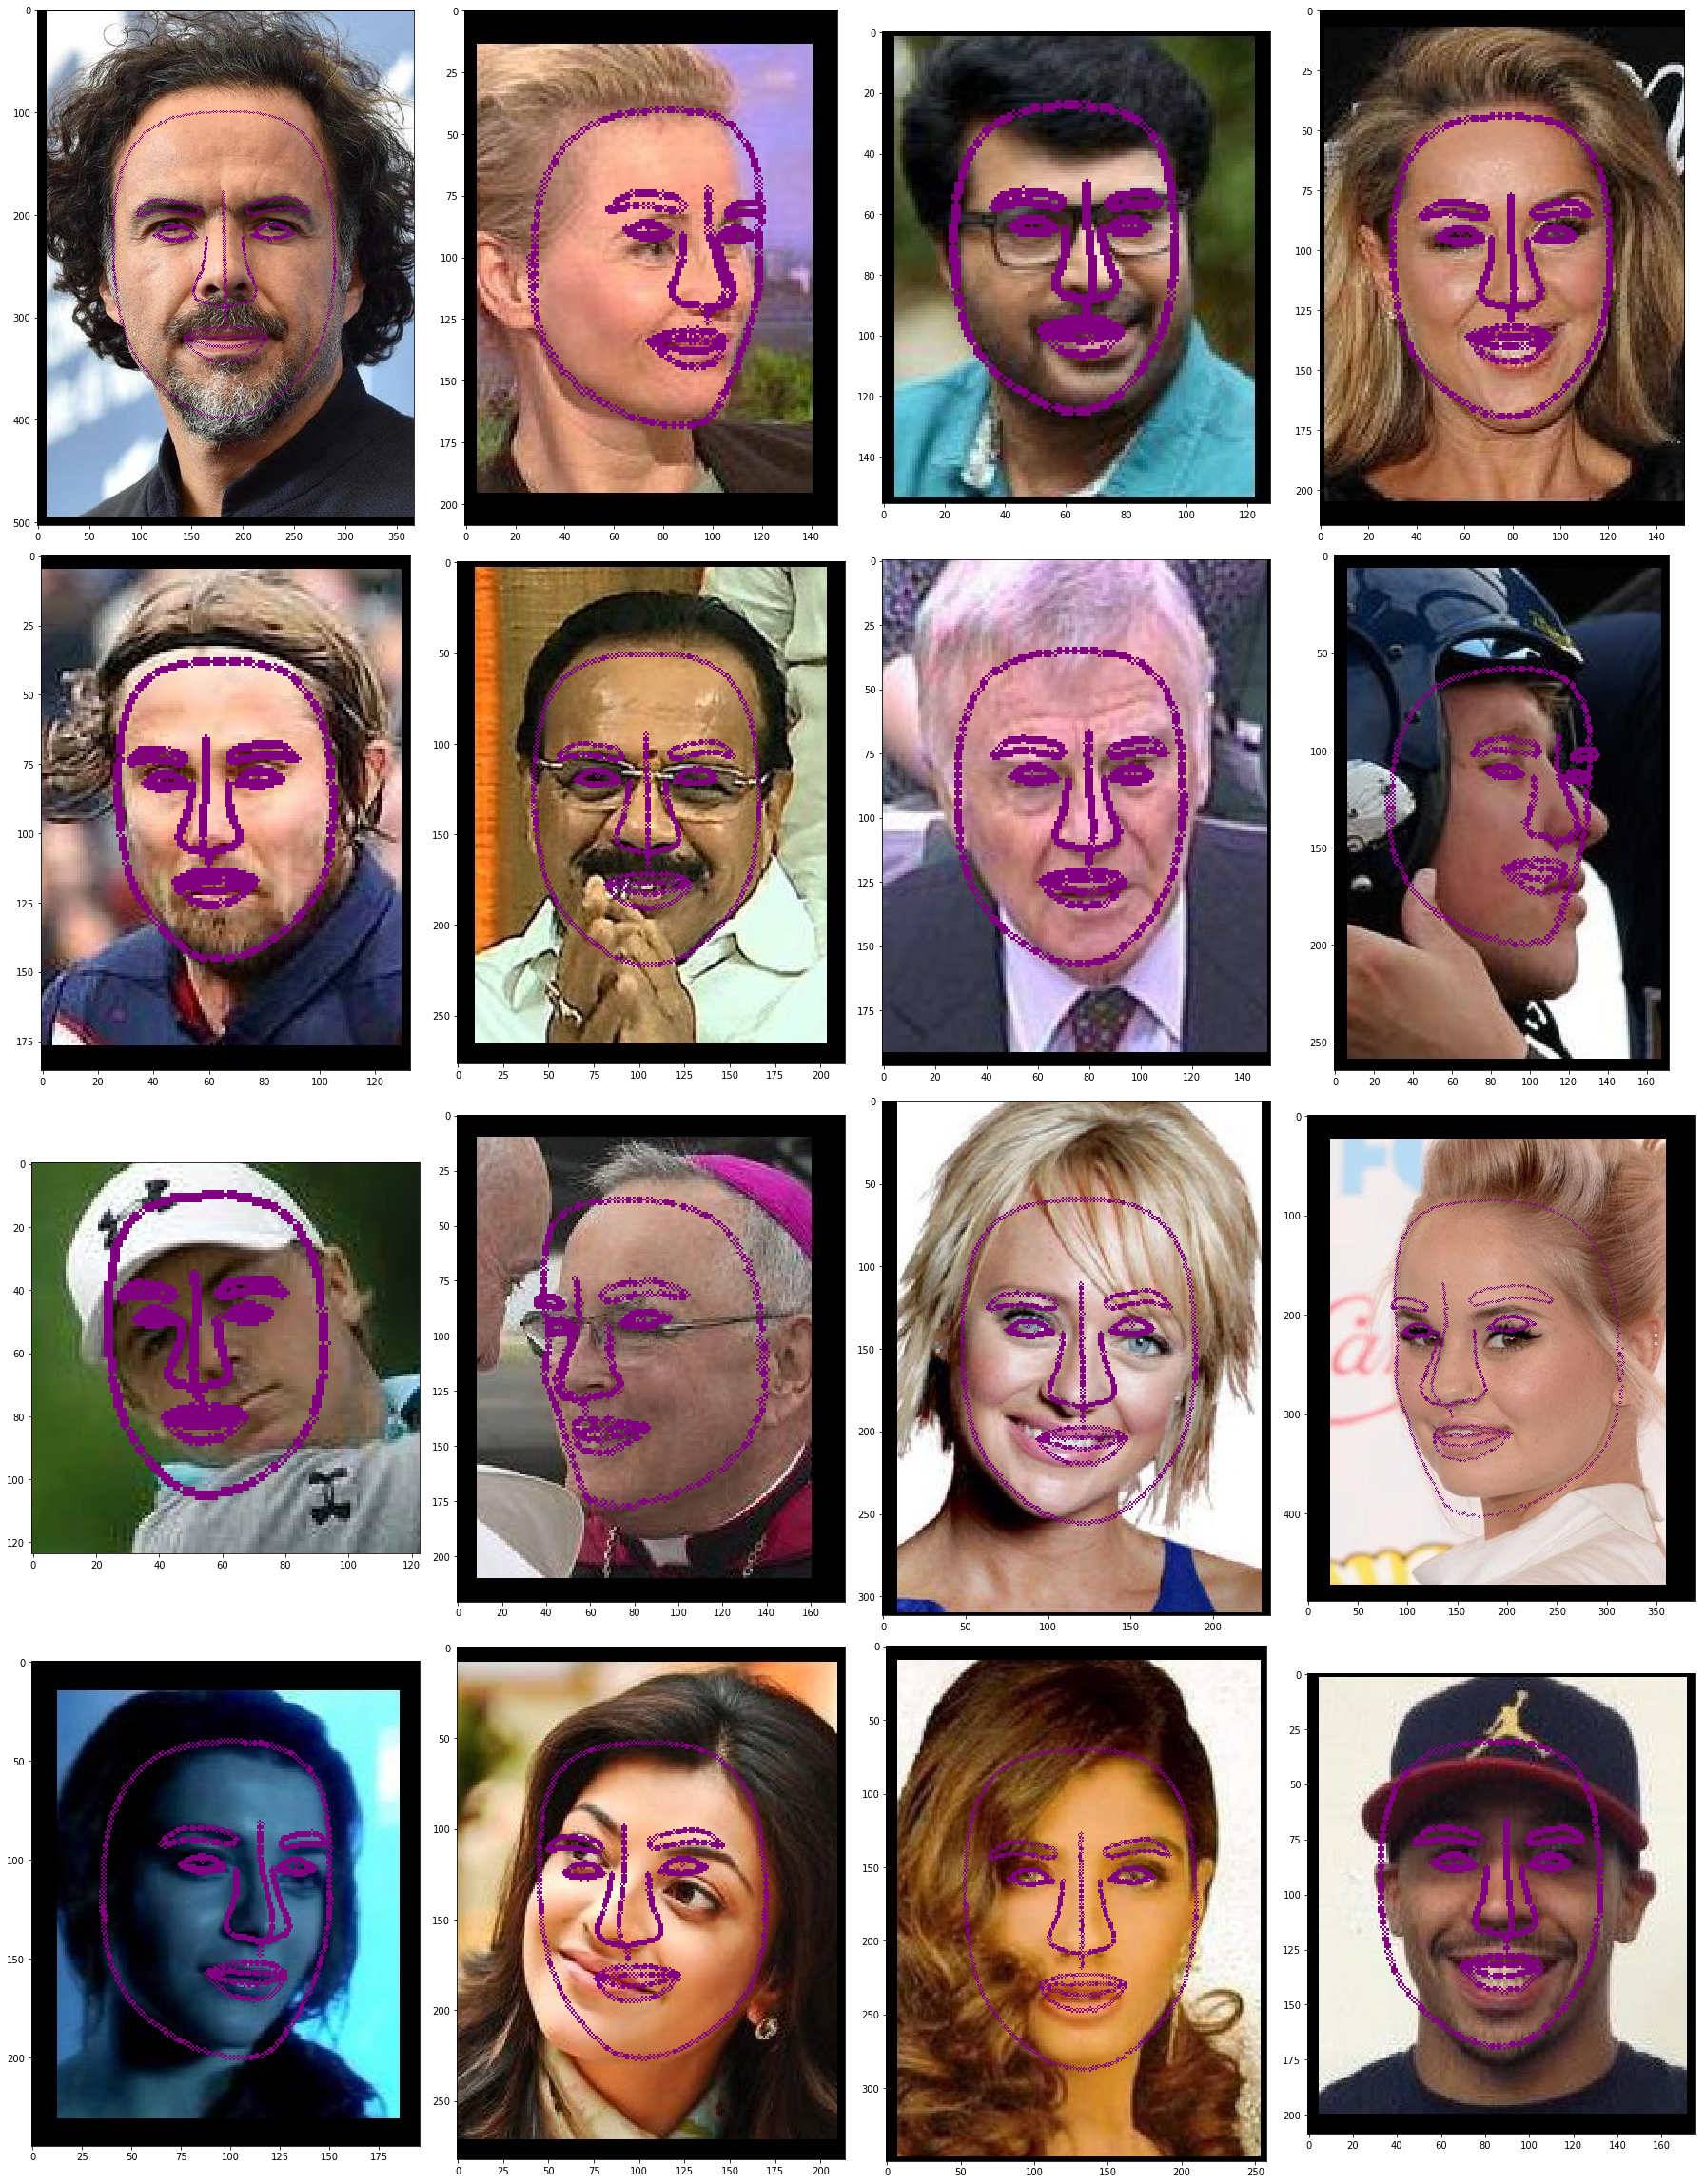

In [32]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()